# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

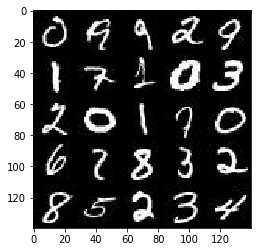

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

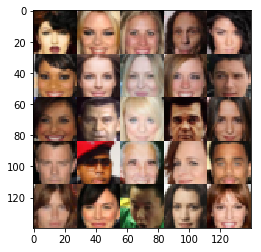

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inp = tf.placeholder(tf.float32, shape = [None, image_width, image_height, image_channels], name = "input")
    z_input = tf.placeholder(tf.float32, shape = [None, z_dim], name = "z_input")
    learning_rate = tf.placeholder(tf.float32, name = "learning_rate" )

    return real_inp, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse): 
      # Input layer is 28x28x3
        alpha = 0.2
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
      
        # 14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
     
        # 7x7x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='valid')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
      
        # 2x2x512

        # Flatten it
        flat = tf.reshape(relu2, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
       
        # 2x2x512 now
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
      
        # 14x14x128 now
        
              
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss
   


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    #inputs
     
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    d_train_opt,g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2 ; #from -0.5 to 0.5 range to -1 to 1 range
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate} )
                _= sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0 or steps == 1:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0 or steps == 1:
                    show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
        show_generator_output(sess, 20, input_z, data_shape[3], data_image_mode)
        print("Done");               
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.5965... Generator Loss: 0.5733


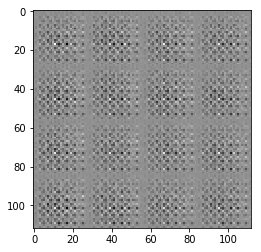

Epoch 1/2... Discriminator Loss: 0.7097... Generator Loss: 1.3794
Epoch 1/2... Discriminator Loss: 0.6654... Generator Loss: 1.5632
Epoch 1/2... Discriminator Loss: 0.8938... Generator Loss: 1.0124
Epoch 1/2... Discriminator Loss: 0.9024... Generator Loss: 1.0403
Epoch 1/2... Discriminator Loss: 1.0130... Generator Loss: 0.9678
Epoch 1/2... Discriminator Loss: 1.0552... Generator Loss: 0.8820
Epoch 1/2... Discriminator Loss: 1.0835... Generator Loss: 0.8890
Epoch 1/2... Discriminator Loss: 1.0562... Generator Loss: 1.0523
Epoch 1/2... Discriminator Loss: 0.9286... Generator Loss: 1.0837
Epoch 1/2... Discriminator Loss: 0.9357... Generator Loss: 1.0555


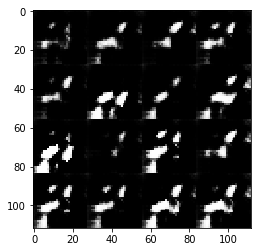

Epoch 1/2... Discriminator Loss: 0.8676... Generator Loss: 1.4207
Epoch 1/2... Discriminator Loss: 0.9265... Generator Loss: 1.1078
Epoch 1/2... Discriminator Loss: 1.3048... Generator Loss: 0.8595
Epoch 1/2... Discriminator Loss: 1.1482... Generator Loss: 0.8661
Epoch 1/2... Discriminator Loss: 0.9183... Generator Loss: 1.0263
Epoch 1/2... Discriminator Loss: 0.9844... Generator Loss: 1.1004
Epoch 1/2... Discriminator Loss: 1.0591... Generator Loss: 1.0283
Epoch 1/2... Discriminator Loss: 0.8842... Generator Loss: 1.2232
Epoch 1/2... Discriminator Loss: 1.0838... Generator Loss: 1.0759
Epoch 1/2... Discriminator Loss: 1.1618... Generator Loss: 1.3866


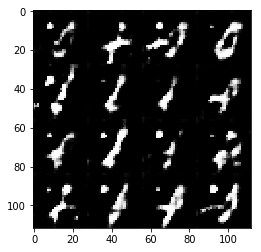

Epoch 1/2... Discriminator Loss: 1.6350... Generator Loss: 1.1898
Epoch 1/2... Discriminator Loss: 1.2178... Generator Loss: 0.8686
Epoch 1/2... Discriminator Loss: 1.0020... Generator Loss: 0.9984
Epoch 1/2... Discriminator Loss: 1.2058... Generator Loss: 1.0333
Epoch 1/2... Discriminator Loss: 1.1854... Generator Loss: 1.0402
Epoch 1/2... Discriminator Loss: 1.0958... Generator Loss: 1.1138
Epoch 1/2... Discriminator Loss: 1.0920... Generator Loss: 0.9245
Epoch 1/2... Discriminator Loss: 1.2144... Generator Loss: 0.8748
Epoch 1/2... Discriminator Loss: 1.0523... Generator Loss: 1.0403
Epoch 1/2... Discriminator Loss: 1.0743... Generator Loss: 0.8588


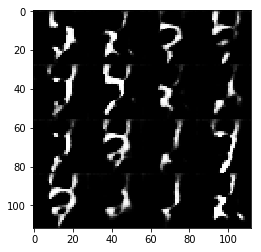

Epoch 1/2... Discriminator Loss: 1.0638... Generator Loss: 0.9055
Epoch 1/2... Discriminator Loss: 1.1378... Generator Loss: 0.8509
Epoch 1/2... Discriminator Loss: 1.1102... Generator Loss: 0.8849
Epoch 1/2... Discriminator Loss: 1.1580... Generator Loss: 0.6905
Epoch 1/2... Discriminator Loss: 1.1125... Generator Loss: 1.0586
Epoch 1/2... Discriminator Loss: 1.1361... Generator Loss: 1.0862
Epoch 1/2... Discriminator Loss: 1.1244... Generator Loss: 0.9640
Epoch 1/2... Discriminator Loss: 1.0850... Generator Loss: 0.8747
Epoch 1/2... Discriminator Loss: 1.1687... Generator Loss: 0.8000
Epoch 1/2... Discriminator Loss: 1.1809... Generator Loss: 0.8521


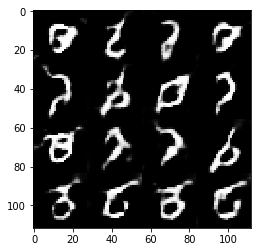

Epoch 1/2... Discriminator Loss: 1.2550... Generator Loss: 0.7972
Epoch 1/2... Discriminator Loss: 4.1593... Generator Loss: 2.1178
Epoch 1/2... Discriminator Loss: 1.2551... Generator Loss: 0.7916
Epoch 1/2... Discriminator Loss: 1.2135... Generator Loss: 0.8096
Epoch 1/2... Discriminator Loss: 1.3518... Generator Loss: 0.7459
Epoch 1/2... Discriminator Loss: 1.2415... Generator Loss: 0.8114
Epoch 2/2... Discriminator Loss: 1.2142... Generator Loss: 0.8293
Epoch 2/2... Discriminator Loss: 1.2172... Generator Loss: 0.8309
Epoch 2/2... Discriminator Loss: 1.2398... Generator Loss: 0.7982
Epoch 2/2... Discriminator Loss: 1.2237... Generator Loss: 0.8002


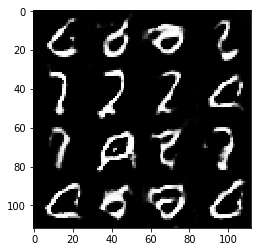

Epoch 2/2... Discriminator Loss: 1.2581... Generator Loss: 0.8478
Epoch 2/2... Discriminator Loss: 1.2402... Generator Loss: 0.7827
Epoch 2/2... Discriminator Loss: 1.2554... Generator Loss: 0.8437
Epoch 2/2... Discriminator Loss: 1.2618... Generator Loss: 0.7753
Epoch 2/2... Discriminator Loss: 1.2396... Generator Loss: 0.8032
Epoch 2/2... Discriminator Loss: 1.2538... Generator Loss: 0.8264
Epoch 2/2... Discriminator Loss: 1.2524... Generator Loss: 0.8738
Epoch 2/2... Discriminator Loss: 1.2566... Generator Loss: 0.8045
Epoch 2/2... Discriminator Loss: 1.3008... Generator Loss: 0.8420
Epoch 2/2... Discriminator Loss: 1.2895... Generator Loss: 0.9081


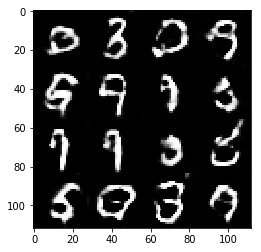

Epoch 2/2... Discriminator Loss: 1.2239... Generator Loss: 0.7407
Epoch 2/2... Discriminator Loss: 1.2477... Generator Loss: 0.7990
Epoch 2/2... Discriminator Loss: 1.2340... Generator Loss: 0.7693
Epoch 2/2... Discriminator Loss: 1.2814... Generator Loss: 0.8535
Epoch 2/2... Discriminator Loss: 1.3354... Generator Loss: 0.8224
Epoch 2/2... Discriminator Loss: 1.1990... Generator Loss: 0.7442
Epoch 2/2... Discriminator Loss: 1.6978... Generator Loss: 1.3677
Epoch 2/2... Discriminator Loss: 1.2350... Generator Loss: 0.8439
Epoch 2/2... Discriminator Loss: 1.2589... Generator Loss: 0.7272
Epoch 2/2... Discriminator Loss: 1.2864... Generator Loss: 0.8407


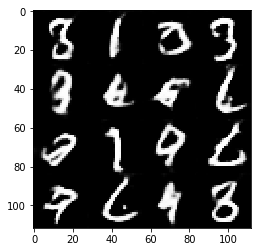

Epoch 2/2... Discriminator Loss: 1.2307... Generator Loss: 0.8216
Epoch 2/2... Discriminator Loss: 1.2466... Generator Loss: 0.7716
Epoch 2/2... Discriminator Loss: 1.2330... Generator Loss: 0.7811
Epoch 2/2... Discriminator Loss: 1.2508... Generator Loss: 0.7566
Epoch 2/2... Discriminator Loss: 1.2435... Generator Loss: 0.7947
Epoch 2/2... Discriminator Loss: 1.2625... Generator Loss: 0.8666
Epoch 2/2... Discriminator Loss: 1.2525... Generator Loss: 0.7590
Epoch 2/2... Discriminator Loss: 1.2389... Generator Loss: 0.8072
Epoch 2/2... Discriminator Loss: 1.2639... Generator Loss: 0.8119
Epoch 2/2... Discriminator Loss: 1.2819... Generator Loss: 0.8250


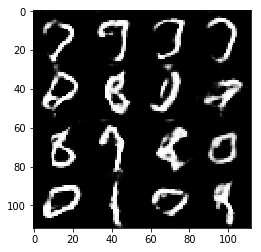

Epoch 2/2... Discriminator Loss: 1.4357... Generator Loss: 0.9847
Epoch 2/2... Discriminator Loss: 1.3410... Generator Loss: 0.8868
Epoch 2/2... Discriminator Loss: 1.2840... Generator Loss: 0.8979
Epoch 2/2... Discriminator Loss: 1.2105... Generator Loss: 0.8281
Epoch 2/2... Discriminator Loss: 1.2879... Generator Loss: 0.7985
Epoch 2/2... Discriminator Loss: 1.2721... Generator Loss: 0.7694
Epoch 2/2... Discriminator Loss: 1.2547... Generator Loss: 0.8058
Epoch 2/2... Discriminator Loss: 1.2380... Generator Loss: 0.7794
Epoch 2/2... Discriminator Loss: 1.2815... Generator Loss: 0.9257
Epoch 2/2... Discriminator Loss: 1.2253... Generator Loss: 0.7644


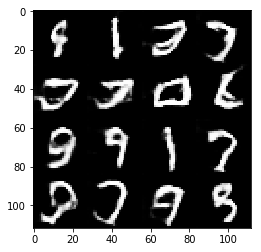

Epoch 2/2... Discriminator Loss: 1.2535... Generator Loss: 0.8187
Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 0.7001
Epoch 2/2... Discriminator Loss: 1.2389... Generator Loss: 0.8381


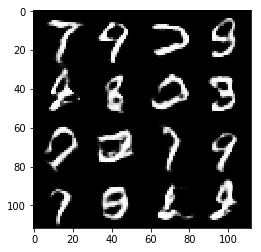

Done


In [19]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 3.8665... Generator Loss: 0.8195


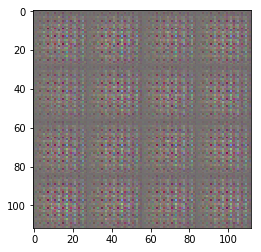

Epoch 1/2... Discriminator Loss: 1.4766... Generator Loss: 1.0403
Epoch 1/2... Discriminator Loss: 1.3653... Generator Loss: 0.9684
Epoch 1/2... Discriminator Loss: 0.8181... Generator Loss: 1.1804
Epoch 1/2... Discriminator Loss: 0.7487... Generator Loss: 1.5681
Epoch 1/2... Discriminator Loss: 1.0947... Generator Loss: 2.4294
Epoch 1/2... Discriminator Loss: 0.6597... Generator Loss: 1.2218
Epoch 1/2... Discriminator Loss: 0.3624... Generator Loss: 2.3278
Epoch 1/2... Discriminator Loss: 0.2345... Generator Loss: 2.3875
Epoch 1/2... Discriminator Loss: 0.2162... Generator Loss: 2.8544
Epoch 1/2... Discriminator Loss: 3.2599... Generator Loss: 2.0894


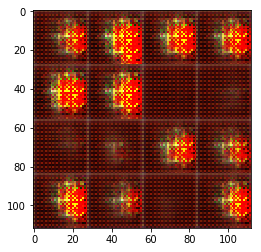

Epoch 1/2... Discriminator Loss: 0.9993... Generator Loss: 0.9995
Epoch 1/2... Discriminator Loss: 1.0751... Generator Loss: 0.8268
Epoch 1/2... Discriminator Loss: 1.3042... Generator Loss: 0.9256
Epoch 1/2... Discriminator Loss: 1.1399... Generator Loss: 0.8844
Epoch 1/2... Discriminator Loss: 1.2771... Generator Loss: 0.6933
Epoch 1/2... Discriminator Loss: 1.2102... Generator Loss: 0.8698
Epoch 1/2... Discriminator Loss: 1.1579... Generator Loss: 1.0306
Epoch 1/2... Discriminator Loss: 1.3576... Generator Loss: 0.6735
Epoch 1/2... Discriminator Loss: 1.2467... Generator Loss: 0.6862
Epoch 1/2... Discriminator Loss: 1.2636... Generator Loss: 0.7252


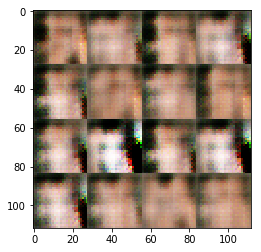

Epoch 1/2... Discriminator Loss: 1.2124... Generator Loss: 0.8482
Epoch 1/2... Discriminator Loss: 1.2252... Generator Loss: 0.9266
Epoch 1/2... Discriminator Loss: 1.3115... Generator Loss: 0.9411
Epoch 1/2... Discriminator Loss: 2.4397... Generator Loss: 1.1311
Epoch 1/2... Discriminator Loss: 1.3467... Generator Loss: 0.6837
Epoch 1/2... Discriminator Loss: 1.3826... Generator Loss: 0.7110
Epoch 1/2... Discriminator Loss: 1.3738... Generator Loss: 0.7056
Epoch 1/2... Discriminator Loss: 1.3527... Generator Loss: 0.7205
Epoch 1/2... Discriminator Loss: 1.6385... Generator Loss: 0.8062
Epoch 1/2... Discriminator Loss: 1.3340... Generator Loss: 0.7221


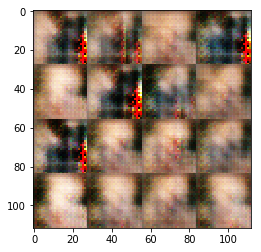

Epoch 1/2... Discriminator Loss: 1.3311... Generator Loss: 0.7209
Epoch 1/2... Discriminator Loss: 1.3238... Generator Loss: 0.7271
Epoch 1/2... Discriminator Loss: 1.3255... Generator Loss: 0.7582
Epoch 1/2... Discriminator Loss: 1.3289... Generator Loss: 0.7421
Epoch 1/2... Discriminator Loss: 1.3080... Generator Loss: 0.7483
Epoch 1/2... Discriminator Loss: 1.2658... Generator Loss: 0.7714
Epoch 1/2... Discriminator Loss: 1.2514... Generator Loss: 0.7448
Epoch 1/2... Discriminator Loss: 1.4109... Generator Loss: 0.7882
Epoch 1/2... Discriminator Loss: 1.2441... Generator Loss: 0.8095
Epoch 1/2... Discriminator Loss: 1.2621... Generator Loss: 0.8247


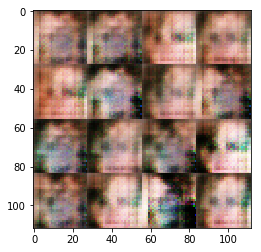

Epoch 1/2... Discriminator Loss: 1.2472... Generator Loss: 0.7574
Epoch 1/2... Discriminator Loss: 1.2276... Generator Loss: 0.7903
Epoch 1/2... Discriminator Loss: 1.2630... Generator Loss: 0.8375
Epoch 1/2... Discriminator Loss: 1.1652... Generator Loss: 0.8673
Epoch 1/2... Discriminator Loss: 1.4148... Generator Loss: 0.6925
Epoch 1/2... Discriminator Loss: 1.3634... Generator Loss: 0.7289
Epoch 1/2... Discriminator Loss: 1.3363... Generator Loss: 0.7452
Epoch 1/2... Discriminator Loss: 1.3227... Generator Loss: 0.7315
Epoch 1/2... Discriminator Loss: 1.3865... Generator Loss: 0.6527
Epoch 1/2... Discriminator Loss: 1.3817... Generator Loss: 0.6427


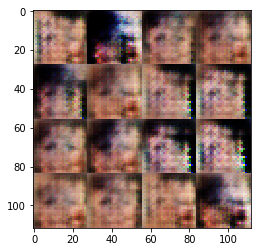

Epoch 1/2... Discriminator Loss: 1.3440... Generator Loss: 0.6954
Epoch 1/2... Discriminator Loss: 1.3609... Generator Loss: 0.7285
Epoch 1/2... Discriminator Loss: 1.3351... Generator Loss: 0.7177
Epoch 1/2... Discriminator Loss: 1.3341... Generator Loss: 0.7160
Epoch 1/2... Discriminator Loss: 1.3224... Generator Loss: 0.7222
Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 0.7279
Epoch 1/2... Discriminator Loss: 1.3451... Generator Loss: 0.7364
Epoch 1/2... Discriminator Loss: 1.3348... Generator Loss: 0.7374
Epoch 1/2... Discriminator Loss: 1.3434... Generator Loss: 0.7246
Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 0.7104


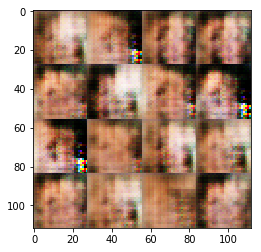

Epoch 1/2... Discriminator Loss: 1.3447... Generator Loss: 0.7072
Epoch 1/2... Discriminator Loss: 1.3508... Generator Loss: 0.7077
Epoch 1/2... Discriminator Loss: 1.3411... Generator Loss: 0.7449
Epoch 1/2... Discriminator Loss: 1.3570... Generator Loss: 0.7336
Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 0.7366
Epoch 1/2... Discriminator Loss: 1.4151... Generator Loss: 0.6817
Epoch 1/2... Discriminator Loss: 1.3730... Generator Loss: 0.7531
Epoch 1/2... Discriminator Loss: 1.3999... Generator Loss: 0.7210
Epoch 1/2... Discriminator Loss: 1.3811... Generator Loss: 0.7191
Epoch 1/2... Discriminator Loss: 1.3336... Generator Loss: 0.7364


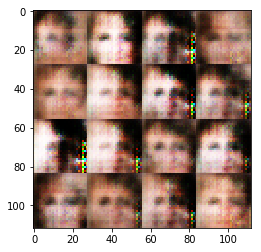

Epoch 1/2... Discriminator Loss: 1.3375... Generator Loss: 0.7289
Epoch 1/2... Discriminator Loss: 1.3373... Generator Loss: 0.7272
Epoch 1/2... Discriminator Loss: 1.3478... Generator Loss: 0.7158
Epoch 1/2... Discriminator Loss: 1.3201... Generator Loss: 0.7378
Epoch 1/2... Discriminator Loss: 1.3021... Generator Loss: 0.7562
Epoch 1/2... Discriminator Loss: 1.3242... Generator Loss: 0.7253
Epoch 1/2... Discriminator Loss: 1.3312... Generator Loss: 0.7142
Epoch 1/2... Discriminator Loss: 1.4273... Generator Loss: 0.7631
Epoch 1/2... Discriminator Loss: 1.3427... Generator Loss: 0.7321
Epoch 1/2... Discriminator Loss: 1.3084... Generator Loss: 0.7364


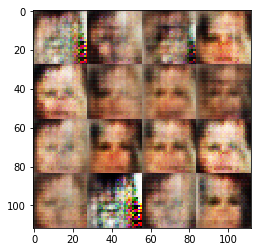

Epoch 1/2... Discriminator Loss: 1.2989... Generator Loss: 0.7496
Epoch 1/2... Discriminator Loss: 1.3607... Generator Loss: 0.8804
Epoch 1/2... Discriminator Loss: 1.2956... Generator Loss: 0.8136
Epoch 1/2... Discriminator Loss: 1.3754... Generator Loss: 0.7060
Epoch 1/2... Discriminator Loss: 1.3310... Generator Loss: 0.7329
Epoch 1/2... Discriminator Loss: 1.3886... Generator Loss: 0.7115
Epoch 1/2... Discriminator Loss: 1.3366... Generator Loss: 0.7343
Epoch 1/2... Discriminator Loss: 1.3807... Generator Loss: 0.7045
Epoch 1/2... Discriminator Loss: 1.3436... Generator Loss: 0.7101
Epoch 1/2... Discriminator Loss: 1.3514... Generator Loss: 0.7453


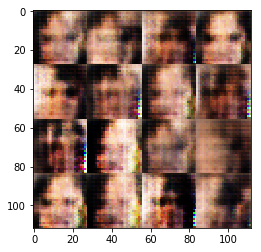

Epoch 1/2... Discriminator Loss: 1.3250... Generator Loss: 0.7029
Epoch 1/2... Discriminator Loss: 1.2970... Generator Loss: 0.7204
Epoch 1/2... Discriminator Loss: 1.3337... Generator Loss: 0.7180
Epoch 1/2... Discriminator Loss: 1.3398... Generator Loss: 0.7280
Epoch 1/2... Discriminator Loss: 1.3998... Generator Loss: 0.7809
Epoch 1/2... Discriminator Loss: 1.3268... Generator Loss: 0.7252
Epoch 1/2... Discriminator Loss: 1.3610... Generator Loss: 0.7563
Epoch 1/2... Discriminator Loss: 1.3143... Generator Loss: 0.7445
Epoch 1/2... Discriminator Loss: 1.3179... Generator Loss: 0.7462
Epoch 1/2... Discriminator Loss: 1.3963... Generator Loss: 0.7420


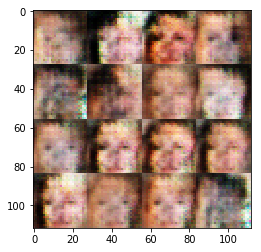

Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 0.7163
Epoch 1/2... Discriminator Loss: 1.3277... Generator Loss: 0.7317
Epoch 1/2... Discriminator Loss: 1.3596... Generator Loss: 0.7423
Epoch 1/2... Discriminator Loss: 1.3339... Generator Loss: 0.7460
Epoch 1/2... Discriminator Loss: 1.2996... Generator Loss: 0.7520
Epoch 1/2... Discriminator Loss: 1.2694... Generator Loss: 0.7536
Epoch 1/2... Discriminator Loss: 1.3382... Generator Loss: 0.7167
Epoch 1/2... Discriminator Loss: 1.3848... Generator Loss: 0.7631
Epoch 1/2... Discriminator Loss: 1.3102... Generator Loss: 0.7426
Epoch 1/2... Discriminator Loss: 1.3106... Generator Loss: 0.7611


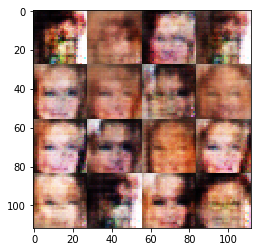

Epoch 1/2... Discriminator Loss: 1.2762... Generator Loss: 0.7665
Epoch 1/2... Discriminator Loss: 1.3125... Generator Loss: 0.7594
Epoch 1/2... Discriminator Loss: 1.4318... Generator Loss: 0.7820
Epoch 1/2... Discriminator Loss: 1.2874... Generator Loss: 0.7436
Epoch 1/2... Discriminator Loss: 1.3176... Generator Loss: 0.7386
Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 0.7325
Epoch 1/2... Discriminator Loss: 1.3531... Generator Loss: 0.7813
Epoch 1/2... Discriminator Loss: 1.3278... Generator Loss: 0.7312
Epoch 1/2... Discriminator Loss: 1.3699... Generator Loss: 0.7565
Epoch 1/2... Discriminator Loss: 1.2787... Generator Loss: 0.7623


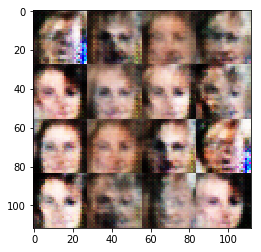

Epoch 1/2... Discriminator Loss: 1.4108... Generator Loss: 0.7414
Epoch 1/2... Discriminator Loss: 1.3573... Generator Loss: 0.7184
Epoch 1/2... Discriminator Loss: 1.3323... Generator Loss: 0.7438
Epoch 1/2... Discriminator Loss: 1.2915... Generator Loss: 0.7602
Epoch 1/2... Discriminator Loss: 1.3162... Generator Loss: 0.7334
Epoch 1/2... Discriminator Loss: 1.3100... Generator Loss: 0.7464
Epoch 1/2... Discriminator Loss: 1.4842... Generator Loss: 0.8286
Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 0.7021
Epoch 1/2... Discriminator Loss: 1.3079... Generator Loss: 0.7455
Epoch 1/2... Discriminator Loss: 1.3318... Generator Loss: 0.7236


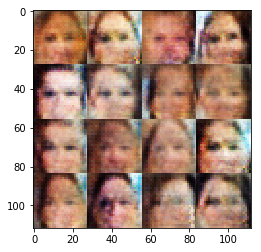

Epoch 1/2... Discriminator Loss: 1.3240... Generator Loss: 0.7306
Epoch 1/2... Discriminator Loss: 1.3290... Generator Loss: 0.7304
Epoch 1/2... Discriminator Loss: 1.7846... Generator Loss: 0.8443
Epoch 1/2... Discriminator Loss: 1.3582... Generator Loss: 0.7208
Epoch 1/2... Discriminator Loss: 1.3688... Generator Loss: 0.6848
Epoch 1/2... Discriminator Loss: 1.3471... Generator Loss: 0.7160
Epoch 1/2... Discriminator Loss: 1.3837... Generator Loss: 0.7862
Epoch 1/2... Discriminator Loss: 1.3047... Generator Loss: 0.7612
Epoch 1/2... Discriminator Loss: 1.3153... Generator Loss: 0.7281
Epoch 1/2... Discriminator Loss: 1.3335... Generator Loss: 0.7490


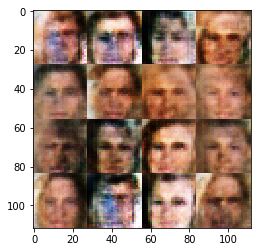

Epoch 1/2... Discriminator Loss: 1.3058... Generator Loss: 0.7341
Epoch 1/2... Discriminator Loss: 1.3442... Generator Loss: 0.7211
Epoch 1/2... Discriminator Loss: 1.3507... Generator Loss: 0.7526
Epoch 1/2... Discriminator Loss: 1.3258... Generator Loss: 0.7431
Epoch 1/2... Discriminator Loss: 1.3263... Generator Loss: 0.7352
Epoch 1/2... Discriminator Loss: 1.3525... Generator Loss: 0.7221
Epoch 1/2... Discriminator Loss: 1.3886... Generator Loss: 0.7182
Epoch 1/2... Discriminator Loss: 1.3533... Generator Loss: 0.7217
Epoch 1/2... Discriminator Loss: 1.3357... Generator Loss: 0.7161
Epoch 1/2... Discriminator Loss: 1.3513... Generator Loss: 0.7208


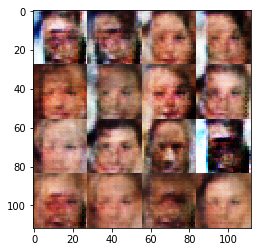

Epoch 1/2... Discriminator Loss: 1.3092... Generator Loss: 0.7620
Epoch 1/2... Discriminator Loss: 1.4138... Generator Loss: 0.7307
Epoch 1/2... Discriminator Loss: 1.3538... Generator Loss: 0.7132
Epoch 1/2... Discriminator Loss: 1.3319... Generator Loss: 0.7008
Epoch 1/2... Discriminator Loss: 1.3655... Generator Loss: 0.7101
Epoch 1/2... Discriminator Loss: 1.5925... Generator Loss: 0.8433
Epoch 1/2... Discriminator Loss: 1.3282... Generator Loss: 0.7762
Epoch 1/2... Discriminator Loss: 1.3428... Generator Loss: 0.7385
Epoch 2/2... Discriminator Loss: 1.3472... Generator Loss: 0.7185
Epoch 2/2... Discriminator Loss: 1.4271... Generator Loss: 0.7645


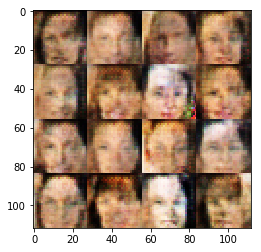

Epoch 2/2... Discriminator Loss: 1.3313... Generator Loss: 0.7442
Epoch 2/2... Discriminator Loss: 1.3553... Generator Loss: 0.7295
Epoch 2/2... Discriminator Loss: 1.3407... Generator Loss: 0.7338
Epoch 2/2... Discriminator Loss: 1.3302... Generator Loss: 0.7250
Epoch 2/2... Discriminator Loss: 1.3251... Generator Loss: 0.7387
Epoch 2/2... Discriminator Loss: 1.4598... Generator Loss: 0.7669
Epoch 2/2... Discriminator Loss: 1.3151... Generator Loss: 0.7341
Epoch 2/2... Discriminator Loss: 1.5318... Generator Loss: 0.7695
Epoch 2/2... Discriminator Loss: 1.3539... Generator Loss: 0.7232
Epoch 2/2... Discriminator Loss: 1.3643... Generator Loss: 0.7418


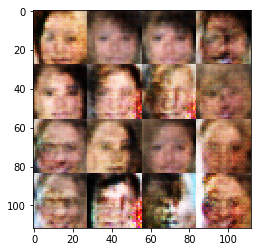

Epoch 2/2... Discriminator Loss: 1.3468... Generator Loss: 0.7291
Epoch 2/2... Discriminator Loss: 1.3303... Generator Loss: 0.7334
Epoch 2/2... Discriminator Loss: 1.3683... Generator Loss: 0.7015
Epoch 2/2... Discriminator Loss: 1.3677... Generator Loss: 0.7176
Epoch 2/2... Discriminator Loss: 1.3356... Generator Loss: 0.7267
Epoch 2/2... Discriminator Loss: 1.3406... Generator Loss: 0.7263
Epoch 2/2... Discriminator Loss: 1.3567... Generator Loss: 0.6915
Epoch 2/2... Discriminator Loss: 1.3671... Generator Loss: 0.6976
Epoch 2/2... Discriminator Loss: 1.3610... Generator Loss: 0.7028
Epoch 2/2... Discriminator Loss: 1.3373... Generator Loss: 0.7228


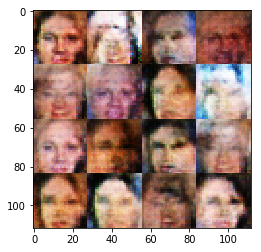

Epoch 2/2... Discriminator Loss: 1.3392... Generator Loss: 0.7254
Epoch 2/2... Discriminator Loss: 1.3457... Generator Loss: 0.7344
Epoch 2/2... Discriminator Loss: 1.3717... Generator Loss: 0.7148
Epoch 2/2... Discriminator Loss: 1.3491... Generator Loss: 0.7181
Epoch 2/2... Discriminator Loss: 1.3550... Generator Loss: 0.7188
Epoch 2/2... Discriminator Loss: 1.3532... Generator Loss: 0.7053
Epoch 2/2... Discriminator Loss: 1.3454... Generator Loss: 0.7015
Epoch 2/2... Discriminator Loss: 1.3579... Generator Loss: 0.7061
Epoch 2/2... Discriminator Loss: 1.3344... Generator Loss: 0.7329
Epoch 2/2... Discriminator Loss: 1.3556... Generator Loss: 0.7076


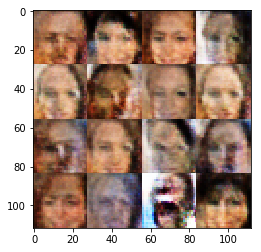

Epoch 2/2... Discriminator Loss: 1.3606... Generator Loss: 0.7090
Epoch 2/2... Discriminator Loss: 1.3275... Generator Loss: 0.7516
Epoch 2/2... Discriminator Loss: 1.3320... Generator Loss: 0.7354
Epoch 2/2... Discriminator Loss: 1.3619... Generator Loss: 0.6967
Epoch 2/2... Discriminator Loss: 1.3388... Generator Loss: 0.7248
Epoch 2/2... Discriminator Loss: 1.3821... Generator Loss: 0.6990
Epoch 2/2... Discriminator Loss: 1.3762... Generator Loss: 0.7156
Epoch 2/2... Discriminator Loss: 1.3437... Generator Loss: 0.7165
Epoch 2/2... Discriminator Loss: 1.3387... Generator Loss: 0.7175
Epoch 2/2... Discriminator Loss: 1.3475... Generator Loss: 0.7483


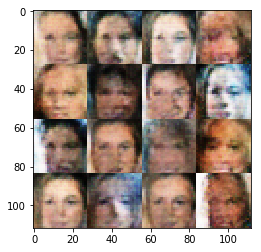

Epoch 2/2... Discriminator Loss: 1.3615... Generator Loss: 0.7285
Epoch 2/2... Discriminator Loss: 1.3486... Generator Loss: 0.7130
Epoch 2/2... Discriminator Loss: 1.3734... Generator Loss: 0.7693
Epoch 2/2... Discriminator Loss: 1.3470... Generator Loss: 0.7407
Epoch 2/2... Discriminator Loss: 1.3694... Generator Loss: 0.7373
Epoch 2/2... Discriminator Loss: 1.3469... Generator Loss: 0.7318
Epoch 2/2... Discriminator Loss: 1.3322... Generator Loss: 0.7493
Epoch 2/2... Discriminator Loss: 1.3916... Generator Loss: 0.6907
Epoch 2/2... Discriminator Loss: 1.3313... Generator Loss: 0.7082
Epoch 2/2... Discriminator Loss: 1.3534... Generator Loss: 0.7579


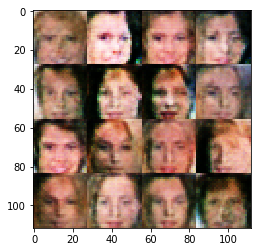

Epoch 2/2... Discriminator Loss: 1.3295... Generator Loss: 0.7414
Epoch 2/2... Discriminator Loss: 1.3262... Generator Loss: 0.6953
Epoch 2/2... Discriminator Loss: 1.3606... Generator Loss: 0.7235
Epoch 2/2... Discriminator Loss: 1.3480... Generator Loss: 0.6856
Epoch 2/2... Discriminator Loss: 1.3950... Generator Loss: 0.7008
Epoch 2/2... Discriminator Loss: 1.3508... Generator Loss: 0.7361
Epoch 2/2... Discriminator Loss: 1.3962... Generator Loss: 0.7249
Epoch 2/2... Discriminator Loss: 1.3740... Generator Loss: 0.7059
Epoch 2/2... Discriminator Loss: 1.3494... Generator Loss: 0.7095
Epoch 2/2... Discriminator Loss: 1.3948... Generator Loss: 0.6843


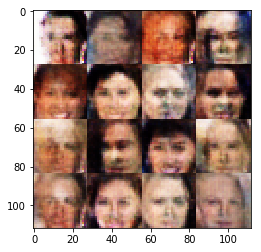

Epoch 2/2... Discriminator Loss: 1.3576... Generator Loss: 0.7114
Epoch 2/2... Discriminator Loss: 1.3978... Generator Loss: 0.6821
Epoch 2/2... Discriminator Loss: 1.3672... Generator Loss: 0.7033
Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 0.7292
Epoch 2/2... Discriminator Loss: 1.3659... Generator Loss: 0.7164
Epoch 2/2... Discriminator Loss: 1.3427... Generator Loss: 0.7362
Epoch 2/2... Discriminator Loss: 1.4233... Generator Loss: 0.7081
Epoch 2/2... Discriminator Loss: 1.3700... Generator Loss: 0.7131
Epoch 2/2... Discriminator Loss: 1.3686... Generator Loss: 0.7077
Epoch 2/2... Discriminator Loss: 1.3547... Generator Loss: 0.7498


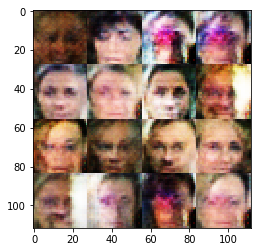

Epoch 2/2... Discriminator Loss: 1.3586... Generator Loss: 0.7204
Epoch 2/2... Discriminator Loss: 1.3467... Generator Loss: 0.7223
Epoch 2/2... Discriminator Loss: 1.6474... Generator Loss: 0.6142
Epoch 2/2... Discriminator Loss: 1.3618... Generator Loss: 0.6954
Epoch 2/2... Discriminator Loss: 1.3524... Generator Loss: 0.7003
Epoch 2/2... Discriminator Loss: 1.3891... Generator Loss: 0.6754
Epoch 2/2... Discriminator Loss: 1.3830... Generator Loss: 0.6851
Epoch 2/2... Discriminator Loss: 1.3611... Generator Loss: 0.7217
Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 0.7029
Epoch 2/2... Discriminator Loss: 1.3586... Generator Loss: 0.7117


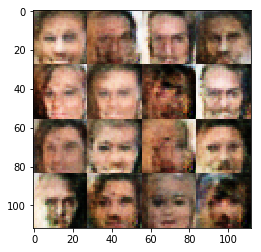

Epoch 2/2... Discriminator Loss: 1.3671... Generator Loss: 0.7128
Epoch 2/2... Discriminator Loss: 1.3753... Generator Loss: 0.7498
Epoch 2/2... Discriminator Loss: 1.3713... Generator Loss: 0.6980
Epoch 2/2... Discriminator Loss: 1.3576... Generator Loss: 0.7001
Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 0.7066
Epoch 2/2... Discriminator Loss: 1.3766... Generator Loss: 0.6948
Epoch 2/2... Discriminator Loss: 1.3721... Generator Loss: 0.6940
Epoch 2/2... Discriminator Loss: 1.3869... Generator Loss: 0.7071
Epoch 2/2... Discriminator Loss: 1.4556... Generator Loss: 0.7706
Epoch 2/2... Discriminator Loss: 1.3759... Generator Loss: 0.6882


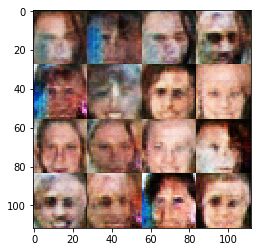

Epoch 2/2... Discriminator Loss: 1.3426... Generator Loss: 0.7203
Epoch 2/2... Discriminator Loss: 1.3738... Generator Loss: 0.6918
Epoch 2/2... Discriminator Loss: 1.3781... Generator Loss: 0.7098
Epoch 2/2... Discriminator Loss: 1.3828... Generator Loss: 0.7062
Epoch 2/2... Discriminator Loss: 1.3738... Generator Loss: 0.6977
Epoch 2/2... Discriminator Loss: 1.3669... Generator Loss: 0.7013
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.7768
Epoch 2/2... Discriminator Loss: 1.3776... Generator Loss: 0.7156
Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 0.7324
Epoch 2/2... Discriminator Loss: 1.3621... Generator Loss: 0.7108


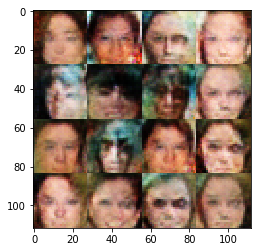

Epoch 2/2... Discriminator Loss: 1.3495... Generator Loss: 0.6924
Epoch 2/2... Discriminator Loss: 1.3673... Generator Loss: 0.7041
Epoch 2/2... Discriminator Loss: 1.3615... Generator Loss: 0.7108
Epoch 2/2... Discriminator Loss: 1.3821... Generator Loss: 0.7155
Epoch 2/2... Discriminator Loss: 1.3793... Generator Loss: 0.7048
Epoch 2/2... Discriminator Loss: 1.3961... Generator Loss: 0.6915
Epoch 2/2... Discriminator Loss: 1.4007... Generator Loss: 0.7637
Epoch 2/2... Discriminator Loss: 1.3712... Generator Loss: 0.7189
Epoch 2/2... Discriminator Loss: 1.3457... Generator Loss: 0.7022
Epoch 2/2... Discriminator Loss: 1.3467... Generator Loss: 0.7153


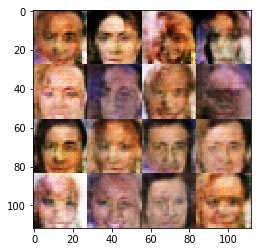

Epoch 2/2... Discriminator Loss: 1.3612... Generator Loss: 0.7203
Epoch 2/2... Discriminator Loss: 1.3697... Generator Loss: 0.6767
Epoch 2/2... Discriminator Loss: 1.3684... Generator Loss: 0.6994
Epoch 2/2... Discriminator Loss: 1.3633... Generator Loss: 0.6944
Epoch 2/2... Discriminator Loss: 1.3753... Generator Loss: 0.6914
Epoch 2/2... Discriminator Loss: 1.3776... Generator Loss: 0.6953
Epoch 2/2... Discriminator Loss: 1.3483... Generator Loss: 0.7445
Epoch 2/2... Discriminator Loss: 1.3611... Generator Loss: 0.7263
Epoch 2/2... Discriminator Loss: 1.3637... Generator Loss: 0.7240
Epoch 2/2... Discriminator Loss: 1.3706... Generator Loss: 0.7053


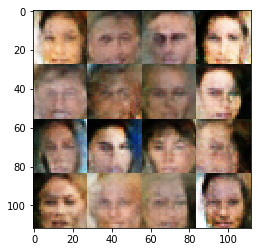

Epoch 2/2... Discriminator Loss: 1.3540... Generator Loss: 0.7235
Epoch 2/2... Discriminator Loss: 1.3569... Generator Loss: 0.6935
Epoch 2/2... Discriminator Loss: 1.3824... Generator Loss: 0.6987
Epoch 2/2... Discriminator Loss: 1.3602... Generator Loss: 0.7044
Epoch 2/2... Discriminator Loss: 1.3741... Generator Loss: 0.7228
Epoch 2/2... Discriminator Loss: 1.3730... Generator Loss: 0.6931
Epoch 2/2... Discriminator Loss: 1.3752... Generator Loss: 0.7165
Epoch 2/2... Discriminator Loss: 1.3648... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 1.3710... Generator Loss: 0.7384
Epoch 2/2... Discriminator Loss: 1.3742... Generator Loss: 0.6810


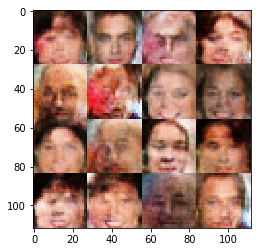

Epoch 2/2... Discriminator Loss: 1.3567... Generator Loss: 0.7271
Epoch 2/2... Discriminator Loss: 1.3715... Generator Loss: 0.6947
Epoch 2/2... Discriminator Loss: 1.3517... Generator Loss: 0.7180
Epoch 2/2... Discriminator Loss: 1.6010... Generator Loss: 0.8419
Epoch 2/2... Discriminator Loss: 1.3841... Generator Loss: 0.6773
Epoch 2/2... Discriminator Loss: 1.3647... Generator Loss: 0.7133
Epoch 2/2... Discriminator Loss: 1.3726... Generator Loss: 0.7293
Epoch 2/2... Discriminator Loss: 1.3672... Generator Loss: 0.7120
Epoch 2/2... Discriminator Loss: 1.3885... Generator Loss: 0.6732
Epoch 2/2... Discriminator Loss: 1.4192... Generator Loss: 0.7325


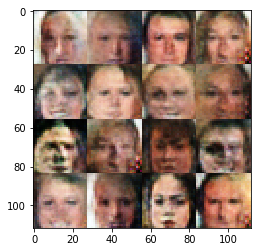

Epoch 2/2... Discriminator Loss: 1.3757... Generator Loss: 0.7131
Epoch 2/2... Discriminator Loss: 1.3813... Generator Loss: 0.7176
Epoch 2/2... Discriminator Loss: 1.3566... Generator Loss: 0.7151
Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 0.7058
Epoch 2/2... Discriminator Loss: 1.3673... Generator Loss: 0.7116
Epoch 2/2... Discriminator Loss: 1.3747... Generator Loss: 0.7177
Epoch 2/2... Discriminator Loss: 1.3607... Generator Loss: 0.7152
Epoch 2/2... Discriminator Loss: 1.3645... Generator Loss: 0.7166
Epoch 2/2... Discriminator Loss: 1.3975... Generator Loss: 0.7067
Epoch 2/2... Discriminator Loss: 1.3682... Generator Loss: 0.7243


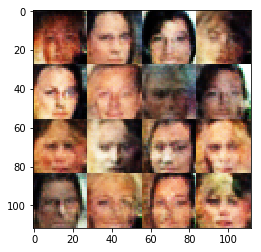

Epoch 2/2... Discriminator Loss: 1.3665... Generator Loss: 0.7273
Epoch 2/2... Discriminator Loss: 1.3650... Generator Loss: 0.6991
Epoch 2/2... Discriminator Loss: 1.3477... Generator Loss: 0.7442
Epoch 2/2... Discriminator Loss: 1.3644... Generator Loss: 0.7529
Epoch 2/2... Discriminator Loss: 1.3684... Generator Loss: 0.7297
Epoch 2/2... Discriminator Loss: 1.3530... Generator Loss: 0.7287


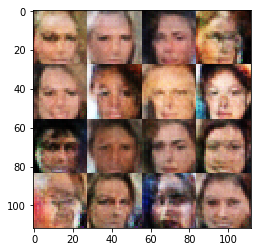

Done


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.